# Exploring Pearson correlation and sample size

Correlation skill of decadal hindcasts is very sensitive to verification period, and the commonly applied block-bootstrapping approach for estimating significance doesn't seem to work very well. This notebook explores this issue and compares a few different approaches for estimating significance.

## Assumptions of correlation:
- Normally distributed
- Homoscedastic (variance same for all values of the independent variable)
- Linear relationship
- Continuous variables
- Paired observations
- No outliers

## Inference

### 1) Boostrap

This is the "standard" approach in decadal forecast assessment

### 2) Student t-distribution

For pairs from an uncorrelated bivariate normal distribution, the sampling distribution of the studentized (sample statistic divided by a sample-based estimate standard deviation) Pearson's correlation coefficient follows Student's t-distribution with degrees of freedom n − 2. i.e.

$t = \frac{r}{\sigma_r} = r \sqrt{\frac{n - 2}{1 - r^2}}$

has a student t-distribution in the null case (this is true approximately even in case of non-normal observed values if sample sizes are large enough [1]). This can be used to determine the "critical values" of Pearson correlation coefficient that must be exceeded to be considered non-zero with a given confidence.

In the case of auto-correlated data, it is common to estimate the effective sample size and use this to estimate the critical values (e.g. [2]), though [3] have shown that it is difficult to estimate the effective sample size reliably.

### 3) Bootstrap (frequency domain)

Another documented approach is to bootstrap in the frequency domain [4]

[1] Kendall, M. G., Stuart, A. (1973) The Advanced Theory of Statistics, Volume 2: Inference and Relationship, Griffin. ISBN 0-85264-215-6 (Section 31.19)

[2] https://www.science.org/doi/full/10.1126/science.1143286

[3] https://doi.org/10.1175/1520-0450(1984)023<0800:TIAEOE>2.0.CO;2

[4] https://doi.org/10.1175/1520-0442(1997)010<2147:AMTETS>2.0.CO;2

In [76]:
import xarray as xr

import seaborn as sns

import matplotlib.pyplot as plt

from src import utils, plot, verify

In [16]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [51]:
plt.rcParams["figure.figsize"] = (15, 6)

In [2]:
DATA_DIR = "../../data/"

## Let's use the CanESM5 sst data for a region in the Tropical Eastern Pacific to explore the behaviour of the correlation

In [79]:
def get_lead(ds, lead):
    return ds.sel(lead=lead).swap_dims({"init": "time"})

In [85]:
region_name = "ETP sst"
region_box = [200, 245, 0, 25]

can = {
    "1-year": (
        utils.extract_lon_lat_box(
            xr.open_zarr(
                f"{DATA_DIR}/processed/CanESM5.annual.anom_1985-2014.sst_global.zarr"
            ),
            ETP_box,
            weighted_average=True,
        )
        .rename({"sst": region_name})
        .compute()
    )
}
months = np.unique(can["1-year"].time.dt.month)

had = {
    "1-year": (
        utils.extract_lon_lat_box(
            xr.open_zarr(
                f"{DATA_DIR}/processed/HadISST.annual.anom_1985-2014.sst_global.zarr"
            ),
            ETP_box,
            weighted_average=True,
        )
        .rename({"sst": region_name})
        .compute()
    )
}
had["1-year"] = had["1-year"].where(had["1-year"].time.dt.month.isin(months), drop=True)

Compute some other temporal averages

In [89]:
average = [2, 4, 8]  # years
for av in average:
    can[f"{av}-year"] = utils.rolling_mean(can["1-year"], window_size=av, dim="lead")
    had[f"{av}-year"] = utils.rolling_mean(had["1-year"], window_size=av, dim="time")

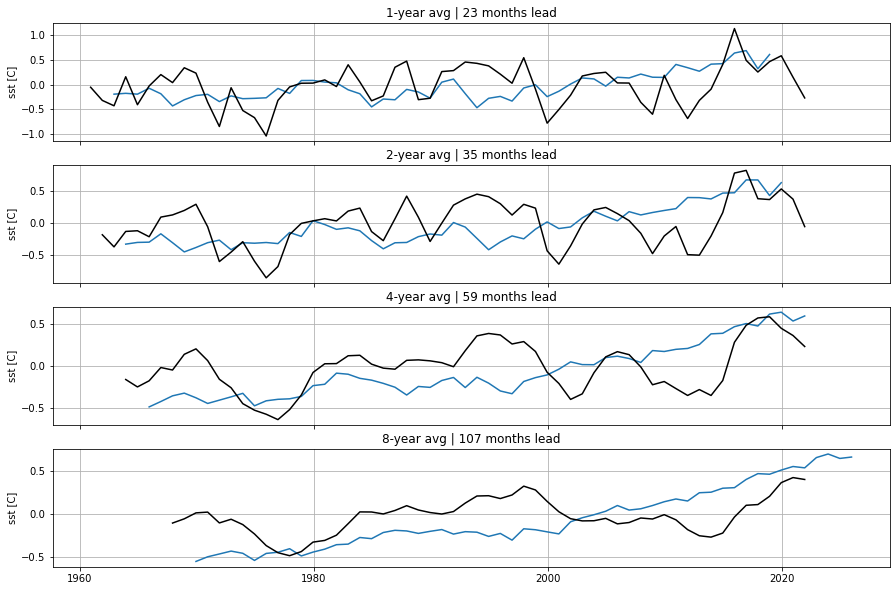

In [114]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(len(can), 1, sharex=True)

for ax, t in zip(axs, can.keys()):
    lead = int(t[0]) * 12 + 11
    get_lead(can[t][region_name].mean("member"), lead).plot(ax=ax)
    had[t][region_name].plot(ax=ax, color="k")
    ax.grid()
    ax.set_title(f"{t} avg | {lead} months lead")
    ax.set_xlabel("")

## How sensitive is the correlation to sample size?

In [228]:
def metric_sample_length_sensitivity(*timeseries, blocksize, metric):
    """
    Test the sensitivity of a metric to the sample length by calculating the metric
    on randomly sampled blocks of specified lengths

    Parameters
    ----------
    timeseries: xarray Datasets
        The timeseries required to calculate the metric, e.g. hindcasts and observations
    blocksize: int or list of int
        The blocksize to recalculate the metric for
    """

    def _n_random_block_indices(size, blocksize):
        """
        Returns indices to randomly resample a single block of a specified length multiple
        times from an array.
        """
        block_starts = np.arange(0, size - blocksize + 1)
        increment = np.arange(blocksize)
        return block_starts + np.expand_dims(increment, axis=1)

    def _sample_blocks(*arrays, indices):
        """Bootstrap the array(s) using the provided indices"""
        blocks = [array[indices] for array in arrays]
        if len(blocks) == 1:
            return blocks[0]
        else:
            return tuple(blocks)

    timeseries = xr.align(*timeseries)
    metric = getattr(verify, metric)

    if isinstance(blocksize, int):
        blocksize = [blocksize]

    res = []
    for i, b in enumerate(blocksize):

        indices = _n_random_block_indices(timeseries[0].sizes["time"], b)

        timeseries_blocks = []
        for obj in timeseries:
            timeseries_blocks.append(
                xr.apply_ufunc(
                    _sample_blocks,
                    obj,
                    kwargs=dict(
                        indices=(..., indices),
                    ),
                    input_core_dims=[["time"]],
                    output_core_dims=[["time", "sample"]],
                    exclude_dims=set(["time"]),
                    dask="parallelized",
                    dask_gufunc_kwargs=dict(
                        output_sizes={"time": b, "sample": indices.shape[-1]}
                    ),
                    output_dtypes=[obj[list(obj.data_vars)[0]].dtype],
                )
            )

        res.append(
            verify._calculate_metric_from_timeseries(
                *timeseries_blocks, metric=metric, metric_kwargs={}, significance=True
            )
            .assign_coords({"blocksize": ("sample", [b] * indices.shape[-1])})
            .assign_coords({"index": ("sample", [i] * indices.shape[-1])})
        )

    return xr.concat(res, dim="sample").to_dataframe()

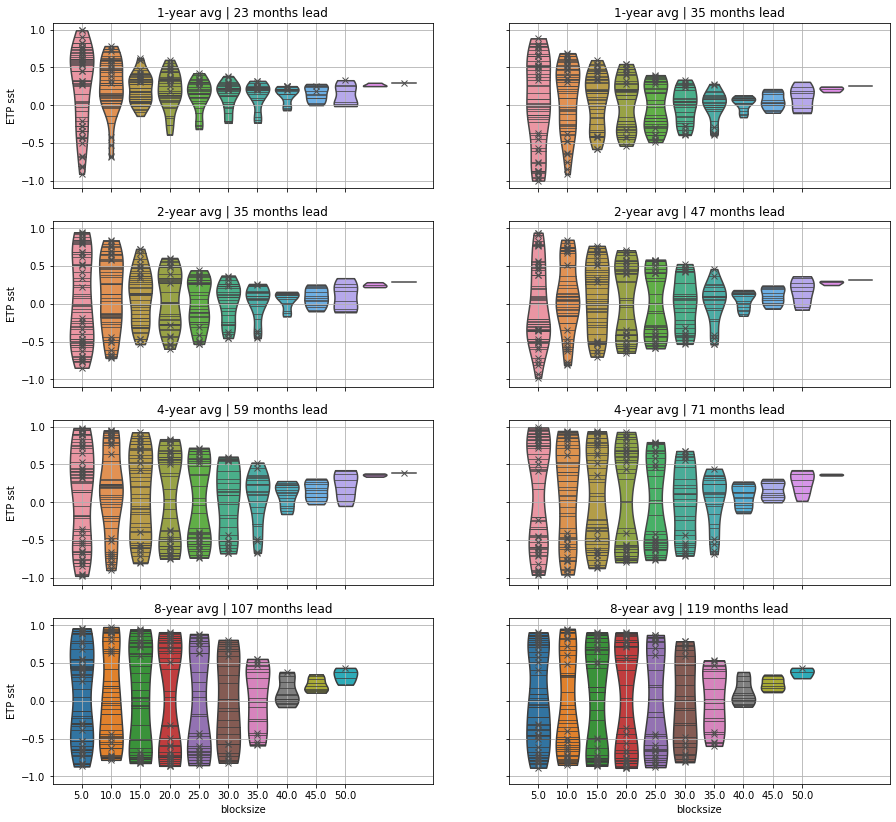

In [249]:
n_leads = 2

fig = plt.figure(figsize=(15, 14))
axs = fig.subplots(len(can), n_leads, sharex=True, sharey=True)

for x, t in enumerate(can.keys()):
    for y, l in enumerate(range(n_leads)):
        lead = (int(t[0]) + l) * 12 + 11
        ax = axs[x, y]
        a = metric_sample_length_sensitivity(
            get_lead(can[t], lead),
            had[t],
            blocksize=list(range(5, 60, 5)) + [57],
            metric="rXY",
        )

        p = sns.violinplot(
            x="blocksize",
            y=region_name,
            data=a,
            cut=0,
            inner="stick",
            scale="width",
            ax=ax,
        )
        ax.plot(
            a["index"][a[f"{region_name}_signif"]],
            a[region_name][a[f"{region_name}_signif"]],
            marker="x",
            linestyle="none",
            color=[0.3, 0.3, 0.3],
        )
        ax.set_title(f"{t} avg | {lead} months lead")
        if x != (len(can) - 1):
            ax.set_xlabel("")
        if y != 0:
            ax.set_ylabel("")
        ax.grid()

### What do these look like for longer periods using the historical simulations?

In [250]:
region_name = "ETP sst"
region_box = [200, 245, 0, 25]

can_hist = {
    "1-year": (
        utils.extract_lon_lat_box(
            xr.open_zarr(
                f"{DATA_DIR}/processed/CanESM5_hist.annual.anom_1985-2014.sst_global.zarr"
            ),
            ETP_box,
            weighted_average=True,
        )
        .rename({"sst": region_name})
        .compute()
    )
}

In [251]:
can_hist

{'1-year': <xarray.Dataset>
 Dimensions:  (member: 40, time: 55)
 Coordinates:
   * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
   * time     (time) object 1960-12-01 00:00:00 ... 2014-12-01 00:00:00
 Data variables:
     ETP sst  (member, time) float32 -0.9177 -0.2331 -0.4787 ... 0.1624 0.498}